# COGSCI 132 Class Project: Hodgkin-Huxley Action Potential Simulator

## Group Members
- Ruhao Tian, SID: 3039823959

## Section 1: Voltage-clamp Experiment Simulation

In this section, the voltage-clamp experiments are conducted to study the change of potassium and sodium currents in Hodgkin-Huxley model. Voltage are stepped to 0 mV, +30 mV and +60 mV, and the potassium and sodium currents are recorded, respectively.

### Implementation

We first implemented two classes: `ODE_integrator` and `Hodgkin_Huxley_Toolkit`. The voltage clamp experiment simulation function is created based on the two classes. 

#### The Ordinary Differential Equation (ODE) Integrator

The `ODE_integrator` class is the key component to solve the ODEs in the Hodgkin-Huxley model. Our integrator has a `method` attribute to specify the numerical method used to solve the ODEs, include Euler's method, Runge-Kutta Second Order method, and Runge-Kutta Fourth Order method. The `ODE_integrator` class has a `integrate` method to solve the ODEs and return the solution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace



class _Integrator():

    def __init__(self,func,y0,t,method="rk4"):
        self.func = func
        self.y0 = y0
        self.t = t
        self.method = method
    
    def integrate(self):
        time_delta_grid = self.t[1:] - self.t[:-1]
        
        y = np.zeros((self.y0.shape[0],self.t.shape[0]))
        y[:,0] = self.y0

        if self.method=="euler":
        
            # Euler Step or Runge-Kutta Second Order Integration Step
            for i in range(time_delta_grid.shape[0]):
                y[:,i+1] = time_delta_grid[i]*self.func(y[:,i],self.t[i])+y[:,i] # Euler Integration Step

        if self.method=="rk2":
            for i in range(time_delta_grid.shape[0]):
                k1=(1/2)*time_delta_grid[i]*self.func(y[:,i],self.t[i])
                breakpoint()
                y[:,i+1] = y[:,i]+time_delta_grid[i]*self.func(y[:,i]+k1,self.t[i]+time_delta_grid[i]/2)
            
        if self.method=="rk4":
       
            for i in range(time_delta_grid.shape[0]):
               k1 = self.func(y[:,i], self.t[i])# RK4 Integration Steps replace Euler's Updation Steps
               half_step = self.t[i] + time_delta_grid[i] / 2
               k2 = self.func(y[:,i] + time_delta_grid[i] * k1 / 2, half_step)
               k3 = self.func(y[:,i] + time_delta_grid[i] * k2 / 2, half_step)
               k4 = self.func(y[:,i] + time_delta_grid[i] * k3, self.t[i] + time_delta_grid[i])
               y[:,i+1]= (k1 + 2 * k2 + 2 * k3 + k4) * (time_delta_grid[i] / 6) + y[:,i]
        
        return y
        

class ODE_integrator():
    def __init__(self,y0,t,func,method):
        self.y0 = np.array(y0)
        self.t = np.array(t)
        if self.check_type(self.y0,self.t):
            self.integrator=_Integrator(func,y0,t,method)
        else:
            print("error encountered")

    def check_type(self,y,t): # Ensure Input is Correct
        return y.dtype == np.floating and t.dtype == np.floating

    def integrate(self):
        return self.integrator.integrate()
    


#### The Hodgkin-Huxley Toolkit

To better represent the variables and their relationships in the Hodgkin-Huxley model, we create a `Hodgkin_Huxley_Toolkit` class. This class includes the following methods:

- `Na_prop`: Calculate the sodium channel activation and inactivation variables, as well as time constants based on the voltage.
- `K_prop`: Calculate the potassium channel activation variables and time constants based on the voltage.
- `I_Na`: Calculate the instantaneous sodium current based on the voltage and the activation and inactivation variables.
- `I_K`: Calculate the instantaneous potassium current based on the voltage and the activation variables.
- `I_L`: Calculate the instantaneous leak current based on the voltage.
- `dmdt`: Calculate the change of the sodium channel activation variable.
- `dhdt`: Calculate the change of the sodium channel inactivation variable.
- `dndt`: Calculate the change of the potassium channel activation variable.

In [2]:
class Hodgkin_Huxley_Toolkit():
    def __init__(self,C_m=1,g_K=10,E_K=-95,g_Na=100,E_Na=50,g_L=0.15,E_L=-55):
        self.C_m = C_m
        self.g_K = g_K
        self.E_K = E_K
        self.g_Na = g_Na
        self.E_Na = E_Na
        self.g_L = g_L
        self.E_L = E_L
    
    def f(self,x):
    
        if abs(x)<1e-12: 
            x=1
        elif x < -20:
            ex = np.exp(x)
            x = -x*ex/(1-ex)
        else: 
            x = x/(1-np.exp(-x))
        return x

    def g(self,x):
        if abs(x)<1e-12: 
            x=1
        else:
            x = x/(np.exp(x)-1)
        return x

    def h(self,x):
        if x < -20:
            x = np.exp(x)/(np.exp(x)+1)
        else: x = 1/(1+np.exp(-x))
        return x

    def K_prop(self,v):
    
    #αn(V ) = 0.032(V + 52)/(1 − exp(−(V + 52)/5))
        def alpha_n(v):
            u= (v+52)/5
            return 0.032*5*self.f(u)
        
        beta_n=0.5*np.exp(-(v+65)/80)
    
        def n_inf(v):
            return (alpha_n(v)/(alpha_n(v)+ beta_n))
        
        def tau_n(v):
            return (1/(alpha_n(v)+beta_n))
        return n_inf(v), tau_n(v)

    def Na_prop(self,v):

        #αm(V) = 0.32(V + 54)/(1 − exp(−(V + 54)/4))
        #βm (V ) = 0.28(V + 27)/(exp((V + 27)/5) − 1)

        def alpha_m(v):
            u = (v+54)/4
            return 4*0.32*self.f(u)

        def beta_m(v):
            u =(v+27)/5
            return 5*0.28*self.g(u)

        def m_inf(v):
            return (alpha_m(v)/(alpha_m(v)+beta_m(v)))

        def tau_m(v):
            return (1 / (alpha_m(v) + beta_m(v)))

        #αh(V) = 0.128 exp(−(V + 50)/18)
        #βh(V) = 4/(1 + exp(−(V + 27)/5)

        alpha_h = 0.128*np.exp(-(v+50)/18)

        def beta_h(v):
            u = (v+27)/5
            return 4*self.h(u)

        def h_inf(v):
            return (alpha_h/(alpha_h+beta_h(v)))

        def tau_h(v):
            return 1/(alpha_h+beta_h(v))
        #set_trace()

        return m_inf(v), tau_m(v), h_inf(v), tau_h(v)

    def I_K(self,V, n):
        return self.g_K  * n**4 * (V - self.E_K)

    def I_Na(self,V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_L(self,V):
        return self.g_L * (V - self.E_L)

    def dmdt(self,V, m):
        m0,tm,h0,th = self.Na_prop(V)
        dmdt = - (1.0/tm)*(m-m0)
        return dmdt
    
    def dhdt(self,V, h):
        m0,tm,h0,th = self.Na_prop(V)
        dhdt = - (1.0/th)*(h-h0)
        return dhdt
    
    def dndt(self,V, n):
        n0,tn = self.K_prop(V)
        dndt = - (1.0/tn)*(n-n0)
        return dndt


#### The voltage-clamp simulation function

The voltage clamp simulation function takes in the `duration` of experiment, voltage `v_clamp`, time step `epsilon`, and a `Hodgkin_Huxley_Toolkit` object. It initializes the initial conditions, time grid, and pass them to an ODE integrator with a function `dXdt` that calculate the derivatives of physical variables at each time step. 

Inside `dXdt`, because the voltage is clamped to a constant value, we simply call the `dmdt`, `dhdt` and `dndt` methods to calculate the change of activation and inactivation variables based on voltage and their value at the previous time step.

Based on those information, the ODE integrator simulates the change of `m`, `h`, `n` over time and returns the solution.

In [3]:

def voltage_clamp_simulation(HH: Hodgkin_Huxley_Toolkit, v_clamp, duration=10, epsilon=0.01):
    
    def dXdt(X,t):
        V = v_clamp
        #V = X[0:1]
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        #dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        out = np.concatenate([HH.dmdt(V, m),HH.dhdt(V,h),HH.dndt(V,n)],0)
        return out

    t = np.arange(0, duration, epsilon)
    
    y0 = np.float64([0,1,0])
    
    integrator = ODE_integrator(y0,t,dXdt,"rk4")

    state = integrator.integrate()
    

    #V = state[3]
    m = state[0]
    h = state[1]
    n = state[2]
    
    return m,h,n

### Results

The durations of voltage-clamp experiments are set to 10 ms, and the time step is set to 0.01 ms. The voltage is stepped to 0 mV, +30 mV and +60 mV, and the potassium and sodium currents are recorded, respectively. The results are plotted in the following figures.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


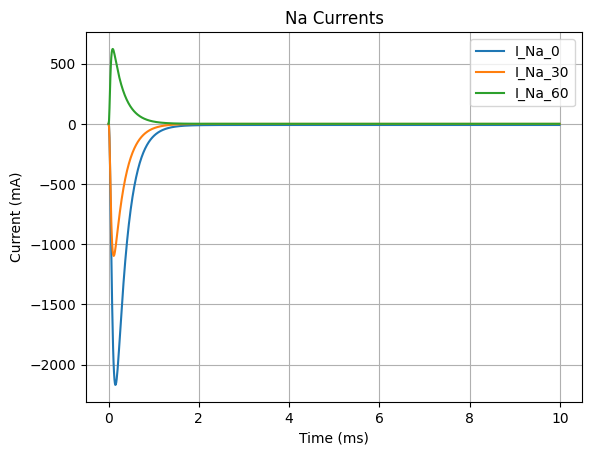

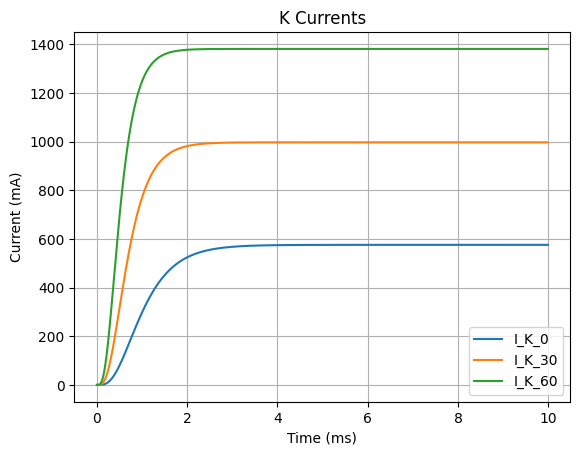

In [4]:
HH = Hodgkin_Huxley_Toolkit()

# time grid
duration = 10 # ms
epsilon = 0.01
t = np.arange(0, duration, epsilon)

# voltage clamp
m0,h0,n0 = voltage_clamp_simulation(HH, 0, duration, epsilon)
m30,h30,n30 = voltage_clamp_simulation(HH, 30, duration, epsilon)
m60,h60,n60 = voltage_clamp_simulation(HH, 60, duration, epsilon)

I_Na_0 = HH.I_Na(0, m0, h0)
I_Na_30 = HH.I_Na(30, m30, h30)
I_Na_60 = HH.I_Na(60, m60, h60)

I_K_0 = HH.I_K(0, n0)
I_K_30 = HH.I_K(30, n30)
I_K_60 = HH.I_K(60, n60)

# plot all Na currents
plt.plot(t,I_Na_0,label='I_Na_0')
plt.plot(t,I_Na_30,label='I_Na_30')
plt.plot(t,I_Na_60,label='I_Na_60')
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('Na Currents')
plt.legend()
plt.grid()
plt.show()

# plot all K currents
plt.plot(t,I_K_0,label='I_K_0')
plt.plot(t,I_K_30,label='I_K_30')
plt.plot(t,I_K_60,label='I_K_60')
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('K Currents')
plt.legend()
plt.grid()
plt.show()

From the figures, we can observe that the sodium current flows into the cell when the voltage is low, and its amplitude decreases as the voltage increases. At +60 mV, the sodium current flows out of the cell. This is because the co-effect of the chemical gradient generated from concentration difference and the electrical gradient generated from the voltage.

- In the beginning of the 0 mV voltage-clamp experiment, the voltage-gated sodium channels are opened. Because the concentration of sodium ions is higher outside the cell, the sodium ions flow into the cell and thus the Na current flow out of the cell is negative.

- When the voltage is clamped to +30 mV, the process of sodium ions flowing into the cell is repeated. However, the electrical gradient is stronger than the previous case, which prevent the sodium ions from flowing into the cell. Thus, the Na current flow out of the cell is smaller than the previous case.

- When the voltage is clamped to +60 mV, according to the Nernst equation, the electrial gradient is stronger than the chemical gradient, which makes the sodium ions flow out of the cell. Thus, the Na current flow out of the cell is positive.

## Section 2: Activation Curves and Time Constants

In this section, we calculate the activation curves and time constants of sodium and potassium channels in the Hodgkin-Huxley model. The activation curves are calculated based on the steady-state activation variables at different voltages.

### Implementation

Given a voltage, the activation variables and time constants of sodium and potassium channels are determined with the `Hodgkin_Huxley_Toolkit` class. To plot the activation curves, we initialize a range of voltages and calculate the activation variables and time constants at each voltage. 

### Results

The activation curves and time constants of sodium and potassium channels are plotted in the following figures.

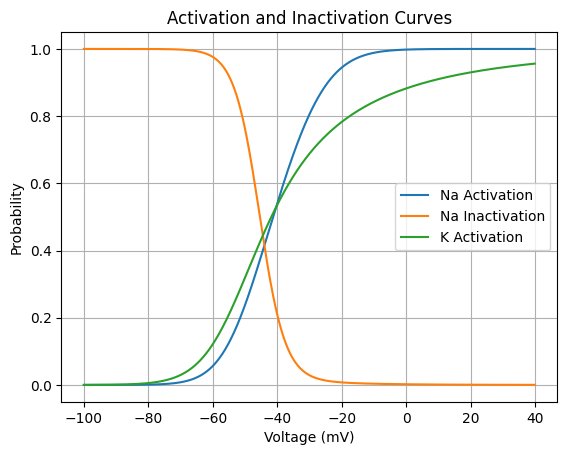

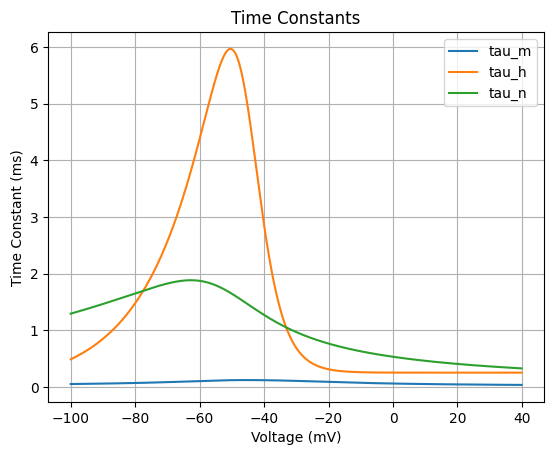

In [5]:
HH = Hodgkin_Huxley_Toolkit()

voltage_gird = np.arange(-100, 40, 0.1)

m_inf = []
h_inf = []
n_inf = []
tau_m = []
tau_h = []
tau_n = []

for v in voltage_gird:
    m0,tm,h0,th = HH.Na_prop(v)
    n0,tn = HH.K_prop(v)
    m_inf.append(m0)
    h_inf.append(h0)
    n_inf.append(n0)
    tau_m.append(tm)
    tau_h.append(th)
    tau_n.append(tn)

# plot the activation and inactivation curves
plt.plot(voltage_gird, m_inf,label='Na Activation')
plt.plot(voltage_gird,h_inf,label='Na Inactivation')
plt.plot(voltage_gird,n_inf,label='K Activation')
plt.xlabel('Voltage (mV)')
plt.ylabel('Probability')
plt.title('Activation and Inactivation Curves')
plt.legend()
plt.grid()
plt.show()

# plot the time constants
plt.plot(voltage_gird,tau_m,label='tau_m')
plt.plot(voltage_gird,tau_h,label='tau_h')
plt.plot(voltage_gird,tau_n,label='tau_n')
plt.xlabel('Voltage (mV)')
plt.ylabel('Time Constant (ms)')
plt.title('Time Constants')
plt.legend()
plt.grid()
plt.show()

## Section 3: Modulated Action Potential

In this section, we simulate the action potential of a neuron with a modulated injected current. The precision of Euler's method is compared with the Runge-Kutta method.

### Implementation

#### Determining the time scale

As signal of different frequency is injected, the time scale should be properly adjusted to prevent aliasing. We implement the Nyquist theorem to determine the time scale.

According to the Nyquist theorem, the sampling frequency should be at least twice the frequency of the signal. Therefore, the time scale should be at most half of the inverse of the frequency of the action potential.

$$
\text{time scale} \leq \frac{1}{2 \times \text{frequency of action potential}}
$$

#### Scaling the frequency of injected current

Because the unit of time scale is in milliseconds, the frequency(Hz) of the injected current should be scaled before calculation. An `1e-3` factor is multiplied to normalize the frequency of injected current.

#### The modulated action potential simulation function

The structure of the modulated action potential simluation function is similar to the voltage-clamp simulation function, except the voltage is not clamped and its change at each time step is calculated as:

$$
\frac{dV}{dt} = \frac{1}{C_m} \left( I_{\text{injected}} - I_{\text{Na}} - I_{\text{K}} - I_{\text{L}} \right)
$$

Where $I_{\text{injected}}$ is the injected current, $I_{\text{Na}}$, $I_{\text{K}}$ and $I_{\text{L}}$ are the sodium, potassium and leak currents, respectively, and $C_m$ is the membrane capacitance.

In [6]:
def modulated_action_potential(HH: Hodgkin_Huxley_Toolkit, duration, epsilon, current_frequency, current_amplitude, method="rk4"):

    def step(state, t):
        V = state[0]
        m = state[1]
        h = state[2]
        n = state[3]

        # current frequency is defined in Hz, so we need to convert it to ms
        I = current_amplitude * np.sin(2 * np.pi * current_frequency * t * 1e-3)

        dVdt = (I - HH.I_Na(V, m, h) - HH.I_K(V, n) - HH.I_L(V)) / HH.C_m
        dmdt = HH.dmdt(V, m)
        dhdt = HH.dhdt(V, h)
        dndt = HH.dndt(V, n)

        return np.array([dVdt, dmdt, dhdt, dndt])
            
    t = np.arange(0, duration, epsilon)
    y0 = np.float64([-65,0,1,0])
    
    integrator = ODE_integrator(y0,t,step,method)

    state = integrator.integrate()

    V = state[0]
    m = state[1]
    h = state[2]
    n = state[3]

    return V, m, h, n

### Results

We modulated the action potential with `20nA` inject current at `10`, `50`, `100`, `500`, `1000` Hz, respectively. At each simulation, the result obtained with Euler's method and RK's methods are plotted into the same plot. The time set of all experiment are set to `0.01ms`, which is far less than the threshold suggested by Nyquist theorem.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


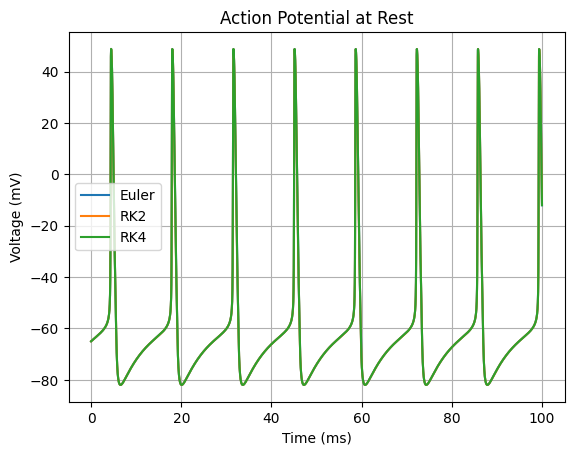

In [7]:
def experiment(HH: Hodgkin_Huxley_Toolkit, duration, epsilon, current_frequency, current_amplitude, method="rk4"):

    time_grid = np.arange(0, duration, epsilon)
    V_euler, m_euler, h_euler, n_euler = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, method)
    V_rk2, m_rk2, h_rk2, n_rk2 = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, "rk2")
    V_rk4, m_rk4, h_rk4, n_rk4 = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, "rk4")

    plt.figure()
    plt.plot(time_grid, V_euler, label='Euler')
    plt.plot(time_grid, V_rk2, label='RK2')
    plt.plot(time_grid, V_rk4, label='RK4')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    if current_frequency == 0:
        plt.title('Action Potential at Rest')
    else:
        plt.title('Action Potential Modulated with {} Hz Current'.format(current_frequency))
    plt.legend()
    plt.grid()
    plt.show()

    return 

HH = Hodgkin_Huxley_Toolkit()

duration = 100
amplitude = 10
epsilon = 0.01

experiment(HH, duration, epsilon, 0, 0)

This figure shows the action potential at rest, for reference.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


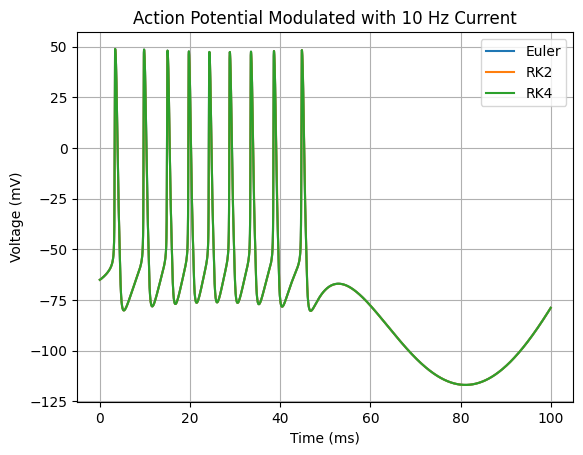

In [8]:
experiment(HH, duration, epsilon, 10, amplitude)


This figure shows the action potential modulated with 10 Hz injected current. In the positive period of the injected current, the hyperpolarization period of action potential is neturalized, so the frequency is significantly increased. In contrast, the negative period of injected current prevent voltage from reaching threshold and removed all action potential.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


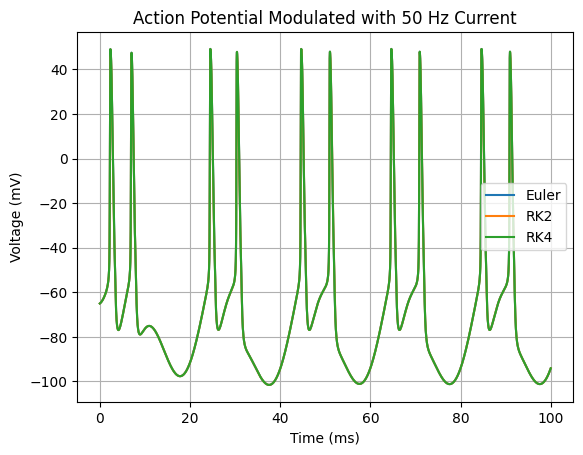

In [9]:
experiment(HH, duration, epsilon, 50, amplitude)


At 50 Hz, the result is similar. The positive period of injected current trigger rapid action potential while the negative part has no action potential.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


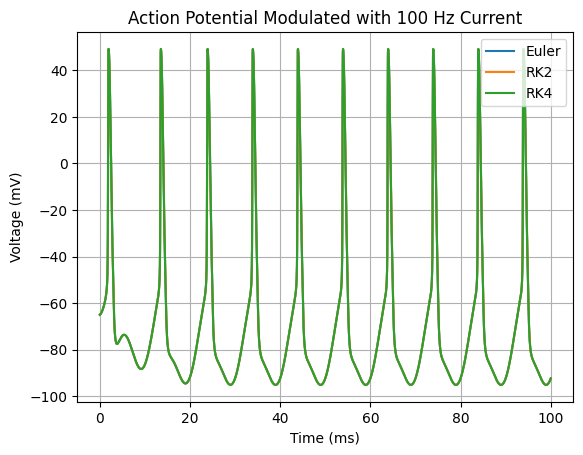

In [10]:
experiment(HH, duration, epsilon, 100, amplitude)


At 100 Hz, where the frequency of injected current approximately matches the action potential frequency at rest, each period of the injected current generate percisely one action potential. The action potential is modulated to the frequency of injected current.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


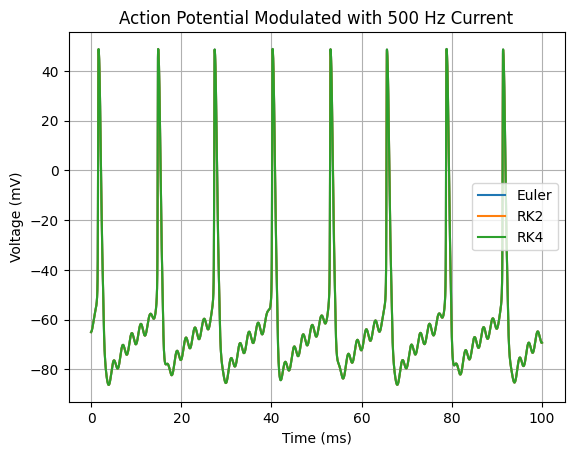

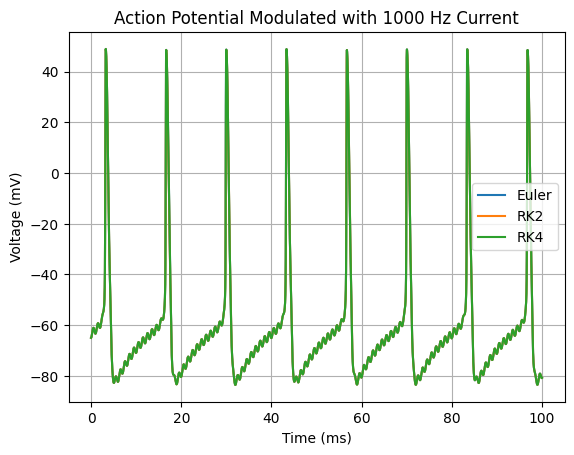

In [11]:
experiment(HH, duration, epsilon, 500, amplitude)
experiment(HH, duration, epsilon, 1000, amplitude)

At 500 Hz and above, because the frequency of injected current is too high, its any effect on the action potential is soon neturalized by itself because of its periodic oscillation. The oscillation in the refactory period is an example.

In this task, there is only very slight difference between result of Euler's method, RK2 and RK4 method in the above figure. Increasing time step expands this difference. Below is an example using `epsilon=0.05ms`, the difference between RK4 and RK2 is obvious.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


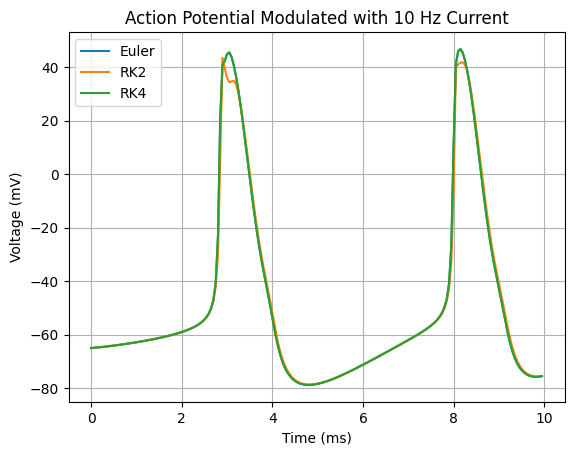

In [12]:
experiment(HH, 10, 0.05, 10, 20)

## Section 4: Precision Comparison

In this section, the precision of Euler's method and Runge-Kutta Second Order method are compared by simulating the action potential voltage of a neuron at rest. The Runge-Kutta Fourth method is used as golden standard.

### Results
The duration of experiment is set to 100 ms, and the time step is set to 0.05 ms. The error of Euler's method and Runge-Kutta Second Order method are calculated at each time step. The results are plotted in the following figure.

/tmp/ipykernel_29761/1204679020.py:57: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


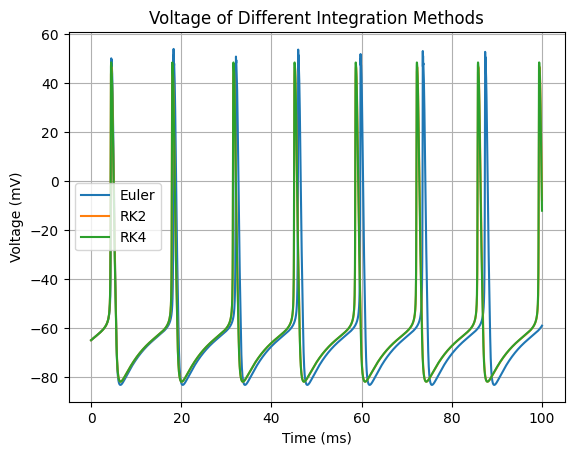

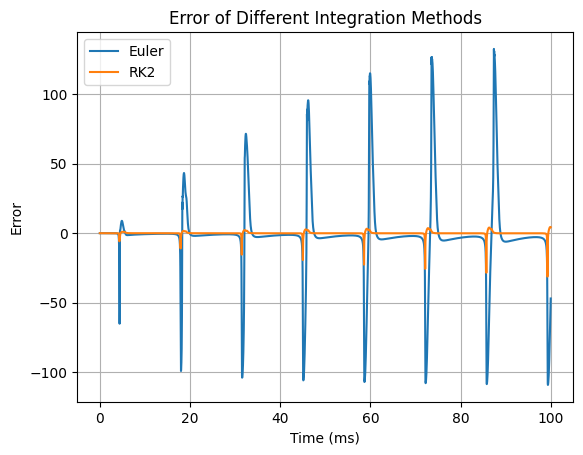

In [15]:
duration = 100
epsilon = 0.03
current_frequency = current_amplitude = 0
time_grid = np.arange(0, duration, epsilon)
V_rk4, m_rk4, h_rk4, n_rk4 = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, "rk4")
V_rk2, m_rk2, h_rk2, n_rk2 = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, "rk2")
V_euler, m_euler, h_euler, n_euler = modulated_action_potential(HH, duration, epsilon, current_frequency, current_amplitude, "euler")

# plot the voltage
plt.plot(time_grid, V_euler, label='Euler')
plt.plot(time_grid, V_rk2, label='RK2')
plt.plot(time_grid, V_rk4, label='RK4')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage of Different Integration Methods')
plt.legend()
plt.grid()
plt.show()

# plot the accuracy
plt.plot(time_grid, V_euler - V_rk4, label='Euler')
plt.plot(time_grid, V_rk2 - V_rk4, label='RK2')
plt.xlabel('Time (ms)')
plt.ylabel('Error')
plt.title('Error of Different Integration Methods')
plt.legend()
plt.grid()
plt.show()

According to the figures, both Euler's method and Runge-Kutta Second Order method produce more significant error when action potential fires. In the refactory period, the error of both method is smaller. At each time step, the error of Euler's method is significantly larger than Runge-Kutta Second Order method error. Additionally, the error of Euler's method surges with time, while the error of RK2 slightly increases.